# Importing Modules

In [1]:
import os
from functools import partial
import numpy as np
import pandas as pd
from scipy.optimize import curve_fit
from scipy.constants import mu_0
from scipy.constants import physical_constants
import matplotlib
import matplotlib.pyplot as plt

import data_tests_functions as dtf

matplotlib.rcParams.update({'font.size': 14})

print('Importing done.')

Importing done.


In [2]:
def round_to_significant_digits(value, sig_digits):
    """
    Rounds a value to a specified number of significant digits.
    :param value: The value to round.
    :param sig_digits: The number of significant digits to round to.
    :return: The rounded value.
    """
    if value == 0:
        raise ValueError("Cannot round a value of 0 to significant digits.")
    digits = -int(np.floor(np.log10(abs(value))) - (sig_digits - 1))
    value_rounded = round(value, digits)
    return value_rounded

# Data directory input

In [3]:
data_dir = 'Co2Fe2H4'

In [4]:
import check_file_and_folder_structure as cffs
cffs.check_structure(data_dir, check_README=True, verbose=True)

The main folder 'Co2Fe2H4' for the dataset exists.
File 'README' exists in the folder 'Co2Fe2H4'.
Subfolder 'GS' exists in the folder 'Co2Fe2H4'.
Subfolder 'GS/x' exists in the folder 'Co2Fe2H4'.
Subfolder 'GS/y' exists in the folder 'Co2Fe2H4'.
Subfolder 'GS/z' exists in the folder 'Co2Fe2H4'.
Subfolder 'Jij' exists in the folder 'Co2Fe2H4'.
Subfolder 'MC' exists in the folder 'Co2Fe2H4'.
File 'out_last' exists in the folder 'Co2Fe2H4/GS/x'.
File 'out_last' exists in the folder 'Co2Fe2H4/GS/y'.
File 'out_last' exists in the folder 'Co2Fe2H4/GS/z'.
File 'structure.cif' exists in the folder 'Co2Fe2H4'.
# All checks passed.


True

In [5]:
data_dir_GS = data_dir + "/GS"
data_dir_MC = data_dir + "/MC"

xyz_dirs = [dirdir for dirdir in os.listdir(data_dir_GS) if len(dirdir) == 1]

print(data_dir_GS)
print(data_dir_MC)
print(xyz_dirs)

Co2Fe2H4/GS
Co2Fe2H4/MC
['y', 'z', 'x']


# Magnetization

In [6]:
# Reading file into lines; all folders are equivalent according to UU-colleagues, so we can use the first one
file_Name_Ms = data_dir_GS + f"/{xyz_dirs[0]}/out_last"
print(file_Name_Ms)

# Create dicts with orbital IDs and values of corresponding
# Total moment and its direction (+/-1)
tot_moments_D = dtf.find_line_val_dict(file_Name_Ms, 'Total moment [J=L+S] (mu_B):')
dir_of_JD = dtf.find_line_val_dict(file_Name_Ms, 'Direction of J (Cartesian):')
print("tot_moments_D:"+str(tot_moments_D))
print("dir_of_JD:"+str(dir_of_JD))
params_merged = {}
for key in tot_moments_D.keys():
    params_merged[key] = tot_moments_D[key] + dir_of_JD[key]

# Pretty table for checking the entries for magnetic moments and directions
df = pd.DataFrame.from_dict(params_merged, orient='index',
                            columns = ['J=L+S (Cartesian)',
                                       'J=L+S (Spin axis)',
                                       'Direction of J (x)',
                                       'Direction of J (y)',
                                       'Direction of J (z)'])
df

Co2Fe2H4/GS/y/out_last
tot_moments_D:{'ID:0102010100-o': [1.107048, 1.107048], 'ID:0101010100-o': [0.005881401, 0.005881401], 'ID:0100010100-o': [0.002925496, 0.002925496], 'ID:0202010100-o': [1.107048, 1.107048], 'ID:0201010100-o': [0.005881401, 0.005881401], 'ID:0200010100-o': [0.002925496, 0.002925496], 'ID:0302010100-o': [2.276975, 2.276975], 'ID:0301010100-o': [0.03871577, 0.03871577], 'ID:0300010100-o': [0.002929676, 0.002929676], 'ID:0402010100-o': [2.276963, 2.276963], 'ID:0401010100-o': [0.03871566, 0.03871566], 'ID:0400010100-o': [0.002929643, 0.002929643], 'ID:0500010100-o': [0.01814711, 0.01814711], 'ID:0600010100-o': [0.01814694, 0.01814694], 'ID:0700010100-o': [0.01814694, 0.01814694], 'ID:0800010100-o': [0.01814711, 0.01814711]}
dir_of_JD:{'ID:0102010100-o': [-8e-08, 0.99999999, -0.00013745], 'ID:0101010100-o': [1e-07, -0.99999994, -0.00034298], 'ID:0100010100-o': [2e-08, -1.0, 6.356e-05], 'ID:0202010100-o': [-8e-08, 0.99999999, 0.00013745], 'ID:0201010100-o': [1e-07, -0

,J=L+S (Cartesian),J=L+S (Spin axis),Direction of J (x),Direction of J (y),Direction of J (z)
ID:0102010100-o,1.107048,1.107048,-8.000000e-08,1.0,-1.374500e-04
ID:0101010100-o,0.005881,0.005881,1.000000e-07,-1.0,-3.429800e-04
ID:0100010100-o,0.002925,0.002925,2.000000e-08,-1.0,6.356000e-05
ID:0202010100-o,1.107048,1.107048,-8.000000e-08,1.0,1.374500e-04
ID:0201010100-o,0.005881,0.005881,1.000000e-07,-1.0,3.429800e-04
ID:0200010100-o,0.002925,0.002925,2.000000e-08,-1.0,-6.356000e-05
ID:0302010100-o,2.276975,2.276975,-9.000000e-08,1.0,-0.000000e+00
ID:0301010100-o,0.038716,0.038716,4.000000e-08,-1.0,-1.000000e-08
ID:0300010100-o,0.002930,0.002930,0.000000e+00,-1.0,0.000000e+00
ID:0402010100-o,2.276963,2.276963,-9.000000e-08,1.0,0.000000e+00


## Calculating magnetization
**Use:** Cartesian (with direction) - we should use that</br>
Spin axis coordinates we ignore

In [7]:
# Calculating total magnetic moment by summing all
# (Total moment (of an orbital) * Direction of J (takes the one with abs value > 0.9, should be +/-1))
tot_magn_mom_C = 0
for key in tot_moments_D.keys():
    tot_magn_mom_C += tot_moments_D[key][0]*[x for x in dir_of_JD[key] if abs(x) > 0.9][0]
    print(tot_moments_D[key][0], '*', 
          [x for x in dir_of_JD[key] if abs(x) > 0.9][0], '=', 
          tot_moments_D[key][0]*[x for x in dir_of_JD[key] if abs(x) > 0.9][0])
    #    total magnetic moment J=L+S * orientation, wherever +/-1 is

print(f'\nTotal magnetic moment = {tot_magn_mom_C}')

# Getting unit cell volume in A^3 from the file
ucv = dtf.find_line_val_dict(file_Name_Ms, 'unit cell volume:')
print(ucv)
# Recalculating in=t in angstroms (should be transferred to m afterwards)
ucvA = ucv[list(ucv.keys())[0]][0] / 1.8897259**3 # unit cell volume in A
print(f'Unit cell volume: {ucvA} A\N{SUPERSCRIPT THREE}')

# Calculating magnetization in Tesla
magnetization_in_T = tot_magn_mom_C/ucvA*11.654
print(f'Magnetization Ms: {magnetization_in_T} T')

1.107048 * 0.99999999 = 1.10704798892952
0.005881401 * -0.99999994 = -0.00588140064711594
0.002925496 * -1.0 = -0.002925496
1.107048 * 0.99999999 = 1.10704798892952
0.005881401 * -0.99999994 = -0.00588140064711594
0.002925496 * -1.0 = -0.002925496
2.276975 * 1.0 = 2.276975
0.03871577 * -1.0 = -0.03871577
0.002929676 * -1.0 = -0.002929676
2.276963 * 1.0 = 2.276963
0.03871566 * -1.0 = -0.03871566
0.002929643 * -1.0 = -0.002929643
0.01814711 * -1.0 = -0.01814711
0.01814694 * -1.0 = -0.01814694
0.01814694 * -1.0 = -0.01814694
0.01814711 * -1.0 = -0.01814711

Total magnetic moment = 6.594541335564807
{'unit': [349.233841348589]}
Unit cell volume: 51.75113447103479 A³
Magnetization Ms: 1.4850454103124426 T


### Q&A
**Question #1:** Why doubled data for each orbital? </br>
<b>Answer #1:</b> because calculations may run several times, that's why we need to take the last one

**Question #2:** How do we calculate total magnetic moment? (Does direction matter?) </br>
<b>Answer #2:</b> the direction does matter. For testing approximate resulting value of Ms should be in the README file, our result should be in 2% range of it

# Anisotropy

In [8]:
energies = {}

if f'out_MF_{xyz_dirs[0]}' in os.listdir(data_dir_GS+f'/{xyz_dirs[0]}'):
    for dirdir in xyz_dirs:
        fileName = data_dir_GS+f"/{dirdir}/out_MF_{dirdir}"
        eigenvalue_sum = dtf.find_line_val_dict(fileName, 'Eigenvalue sum:')
        energies[dirdir] = eigenvalue_sum[list(eigenvalue_sum.keys())[0]][0]
elif f'out_Etot_{xyz_dirs[0]}' in os.listdir(data_dir_GS+f'/{xyz_dirs[0]}'):
    for dirdir in xyz_dirs:
        fileName = data_dir_GS+f"/{dirdir}/out_Etot_{dirdir}"
        energies[dirdir] = dtf.get_energy_from_file(fileName)
else:
    print('no files for anisotropy')

allKs = list()
if 'z' in energies.keys():
    if 'x' in energies.keys():
        Kxz = (energies['x'] - energies['z'])/ucvA*2179874
        allKs.append(Kxz)
    if 'y' in energies.keys():    
        Kyz = (energies['y'] - energies['z'])/ucvA*2179874
        allKs.append(Kyz)

K = max(allKs) * 1e6            # anisotropy J/m³

print(f'Anisotropy constant (max of all): {K} J/m\N{SUPERSCRIPT THREE}')

Anisotropy constant (max of all): 2815104.09991718 J/m³


# Exchange

Number of atoms: 4
Tc = 1080.0 K
1.4417993380865028 1.8366897201149448
spin wave stiffness constant  1.9952086458696177e-40
exchange constant at T=0 6.171002490114324e-12
Js_300 (T) 1.3187125142846379
A_300 (J/m) 5.162336775032497e-12
K_300 (MJ/m) 2.153924005764917
5.162336775032497e-12
1.3187125142846379
Lex  1.931425544671778


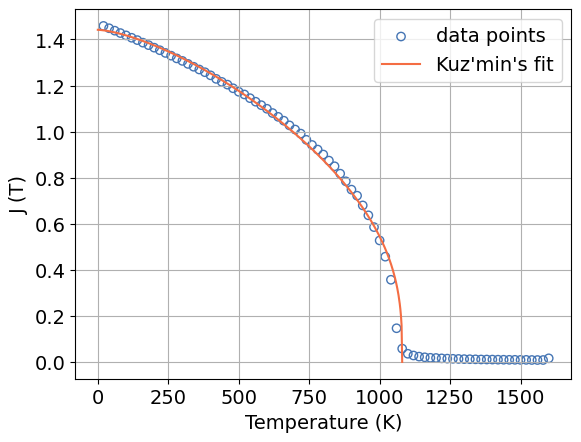

In [9]:
# Define the form of the function you want to fit
fn = data_dir_MC + '/M(T)'  # magnetic polarization
TK, Js = dtf.read_2_col_data(fn)

with open(data_dir_MC + '/momfile', 'rt') as f:
    n_atoms = len(f.read().splitlines())
print(f'Number of atoms: {n_atoms}')

Js = [item*n_atoms/ucvA*11.654 for item in Js]

poscut = np.argmin(np.diff(Js)/np.diff(TK))+2
Tc = TK[poscut]
print(f'Tc = {Tc} K')
TKc = TK[:poscut].copy()
Jsc = Js[:poscut].copy()

xfine = np.linspace(0, Tc, 500)
p    = 5.0 / 2
beta = 1. / 3
m_s = partial(dtf.spontaneous_magnetization, p=p, beta=beta, T_C=Tc)

popt, pcov = curve_fit(m_s, TKc, Jsc)
Js_0, s = popt
print(Js_0, s)
T_fit = np.linspace(min(TKc), max(TKc), 500)
Js_fit = m_s(T_fit, Js_0, s)

g = 2
k_b = physical_constants["Boltzmann constant"][0]
mu_b = physical_constants["Bohr magneton"][0]

M_0 = Js_0/mu_0
D = (0.1509
     * ((g * mu_b) / (s * beta * M_0)) ** (2. / 3)
     * k_b
     * Tc
     )
print("spin wave stiffness constant ",D)
A_0 = M_0 * D / (2 * g * mu_b)
print("exchange constant at T=0",A_0)

Js_300 = m_s(300., Js_0, s)
print("Js_300 (T)",Js_300)

A_300 = A_0*(Js_300/Js_0)**2
print("A_300 (J/m)",A_300)

K_300 = K*(Js_300/Js_0)**3
print("K_300 (MJ/m)",K_300/1e6)

# A = A_0*(Js/Js0)^2
print(A_300)
print(Js_300)
print('Lex ',np.sqrt(mu_0*A_300/(Js_300*Js_300))/1e-9)


plt.scatter(TK, Js, marker="o", label="data points", facecolors='none', edgecolors='#4575b4')
label = "Kuz'min's fit"  # fr"fit $f(x) = ax^2 + bx + c$ with {a=:.3} {b=:.3} {c=:.3}"
plt.plot(xfine, m_s(xfine, Js_0, s), label=label, color='#f46d43')
plt.legend()
plt.xlabel("Temperature (K)")
plt.ylabel("J (T)")
plt.grid()
# plt.style.use('seaborn-v0_8')
plt.show()
plt.close()

### Data from README file for doublechecking

In [10]:
# Ms - Saturation Magnetization
# MAE - Magnetic Anisotropy Energy
with open(data_dir + '/README', 'rt') as f:
    print(f.read())

Ms = 1.49572829 T

MAE
x - z = 2.77 MJ/m³
y - z = 2.81 MJ/m³



### Summary of values computed from the dataset

In [11]:
print(" Ms = "+str(round_to_significant_digits(magnetization_in_T, 4)) + " T")
print(" K = " + str(round_to_significant_digits(K/1e6, 4)) + " MJ/m^3")

 Ms = 1.485 T
 K = 2.815 MJ/m^3


In [12]:
deviation_in_percent = 100 - (1.485 / 1.49572829) * 100
print(" Deviation in percent = "+str(round_to_significant_digits(deviation_in_percent, 4)) + " %")

 Deviation in percent = 0.7173 %
